In [4]:
import numpy as np
import array
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from numpy import intersect1d
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from lmfit.models import VoigtModel
from scipy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

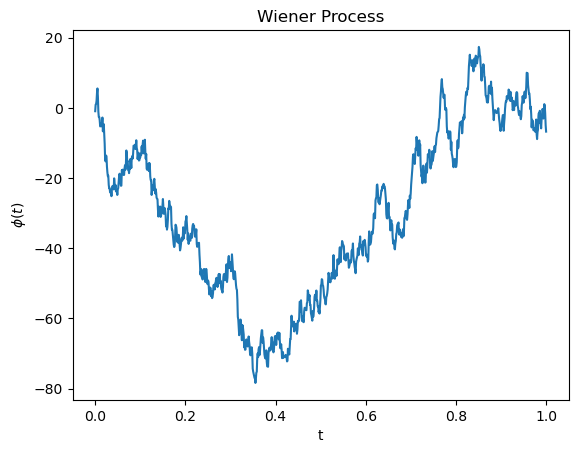

In [224]:
def generate_phase_noise(dt, num_steps):
    # Generate uncorrelated Gaussian random numbers
    random_numbers = np.random.normal(0, 1, num_steps)

    # Compute the phase noise signal
    phase_noise = np.cumsum(random_numbers) * np.sqrt(dt/tc)

    return phase_noise

# Parameters
tc = (1/np.pi) * (1/1E3)
tau = 100 * tc
num_steps = 1000   # Number of time steps
dt = (1/num_steps)     # Time step size

#tau_values = np.linspace(0, tau, num_steps)
# Generate the phase noise signal
phase_noise = generate_phase_noise(dt, num_steps)
shifted = np.roll(phase_noise, int(tau/tc))

# Calculate the mean square difference at different times t and t+tau
#mse_values = []
#for tau1 in tau_values:
    #shifted_pn = np.concatenate((phase_noise[int(tau1/dt):], np.zeros(int(tau1/dt))))
    #mse = np.mean((phase_noise[:num_steps-int(tau1/dt)] - shifted_pn[:num_steps-int(tau1/dt)])**2)
    #mse_values.append(mse)

#expected = tau_values/tc
time = np.linspace(0, dt * num_steps, num_steps)
plt.plot(time , phase_noise , label = 'noise')
plt.xlabel('t')
plt.ylabel(r'$\phi(t)$')
plt.title('Wiener Process')
plt.show()


# Plot the mean square difference as a function of tau
#plt.plot(tau_values, mse_values, label = 'simulated' )
#plt.plot(tau_values, expected, label = 'theoretical')
#plt.xlabel(r'$\tau$')
#plt.ylabel(r'$<(\phi(t)-\phi(t-\tau))^2>$')
#plt.title('Mean Square Difference of Phase Noise at Different Delay Times')

#plt.show()

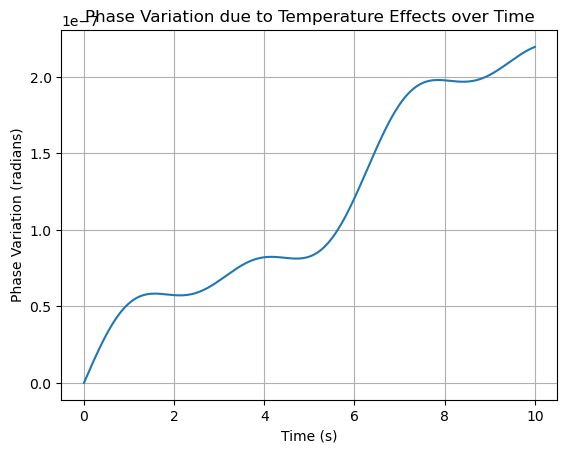

In [231]:
c = 3e8

def calculate_phase_variation(temperature_profile, fiber_length, temperature_coefficient, thermo_optic_coefficient, n, time):
    phase_variation = np.zeros_like(temperature_profile)
    
    for i in range(1, len(temperature_profile)):
        delta_T = temperature_profile[i] - temperature_profile[i-1]
        delta_L = fiber_length * temperature_coefficient * delta_T
        phase_variation[i] = phase_variation[i-1] + (central_frequency * fiber_length/c)  * (thermo_optic_coefficient * delta_T +  n * temperature_coefficient) * delta_T      
         
    
    return phase_variation

# Parameters
time = np.linspace(0, 10, len(phase_noise))  # Time array
temperature_profile = np.sin(time) * 10 # Example temperature profile in degrees Celsius
fiber_length = 1000  # Length of the fiber optic cable in meters
temperature_coefficient = 5.6e-7  # Temperature coefficient of expansion in 1/°C
thermo_optic_coefficient = 1.06e-5
n = 1

# Calculate phase variation over time
phase_temperature_variation = calculate_phase_variation(temperature_profile, fiber_length, temperature_coefficient, thermo_optic_coefficient, n, time)

# Plot the phase variation over time
plt.plot(time, phase_temperature_variation)
plt.xlabel('Time (s)')
plt.ylabel('Phase Variation (radians)')
plt.title('Phase Variation due to Temperature Effects over Time')
plt.grid(True)
plt.show()

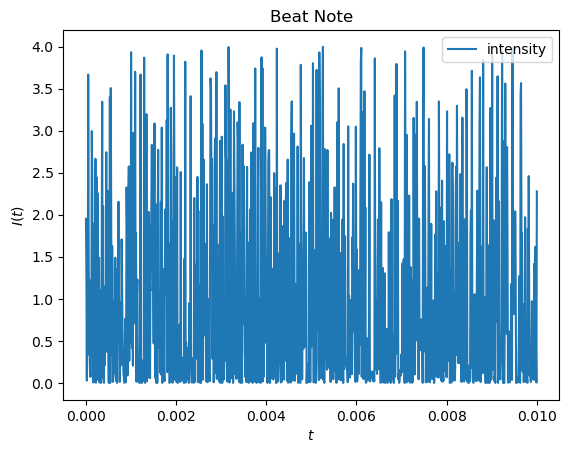

In [226]:
t_max = 1E-2
central_frequency = 2 * np.pi * 200
modulated_frequency = 1E12
t = np.linspace(0, t_max, len(phase_noise))
pn = 1
tn = 0
po = 1
wave1 = po *np.cos(2 * np.pi * central_frequency * t + pn *  phase_noise)
wave2 = po * np.cos(2 * np.pi * (central_frequency + modulated_frequency) * (t-tau) + pn * shifted + phase_temperature_variation)
intensity = abs(wave1 + wave2)**2

# Plot the intensity
plt.plot(t, intensity, label='intensity')
plt.xlabel(r'$t$')
plt.ylabel(r'$I(t)$')
plt.title('Beat Note')
plt.legend()
plt.show()


acorr = np.correlate(intensity, intensity, mode = 'full')

lags  = np.arange(len(acorr))


In [227]:
sp = np.fft.fft(abs(acorr))
sp = sp/max(sp)

sampling_time = (tc/num_steps)

freq  = np.fft.fftfreq(len(sp), sampling_time)
sp = np.fft.fftshift(sp)
sp = abs(sp)**2/max(sp)
freq = np.fft.fftshift(freq)
linewidth = 1/(np.pi*tc)

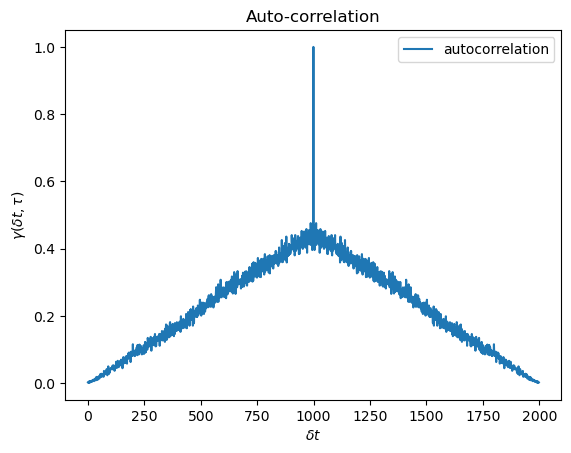

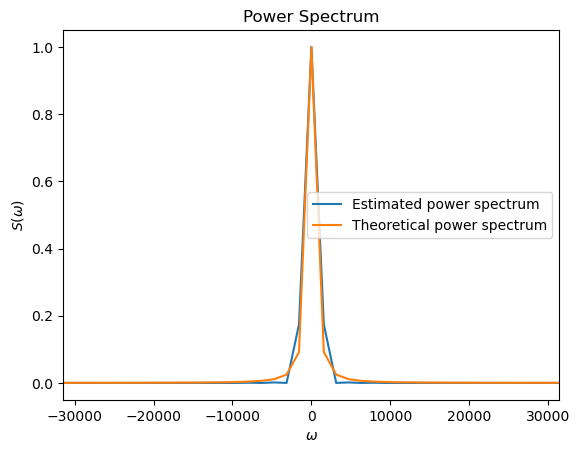

In [228]:
gamma = 1/tc
lorentz = 2*gamma/((2*np.pi*freq)**2+gamma**2)
lorentz = lorentz/max(lorentz)

# Plot the auto-correlation
plt.plot(np.arange(len(acorr)), acorr/max(acorr), label='autocorrelation')
plt.xlabel(r'$\delta t$')
plt.ylabel(r'$\gamma(\delta t, \tau)$')
plt.title('Auto-correlation')
plt.legend()
plt.show()

#Plot the spectrum
plt.plot(freq, sp, label='Estimated power spectrum')
plt.plot(freq, lorentz, label= 'Theoretical power spectrum')

plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.title('Power Spectrum')
plt.xlim(-round(10/tc), round(10/tc))
plt.legend()
plt.show()


In [229]:
x = freq
y = abs(sp)**2

# Define the Voigt model
voigt_model = VoigtModel()

# Set initial parameter guesses
params = voigt_model.guess(y, x=x)

# Perform the fit
result = voigt_model.fit(y, params, x=x)

vf = result.best_fit

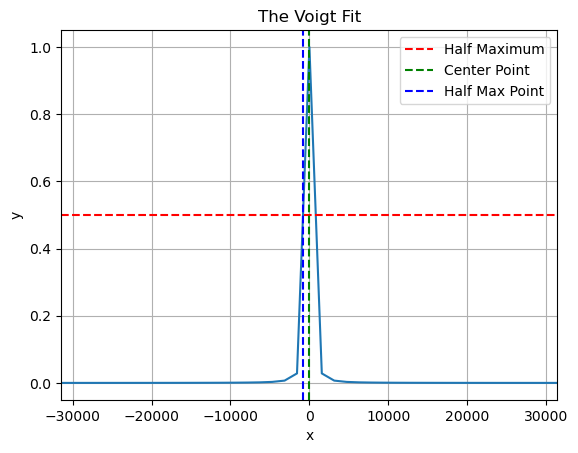

Estimated linewidth: 1029.6455600395323 Hz
Theoretical Linewidth Linewidth: 1000.0 Hz


In [230]:
## x = freq
y = vf 

# Target y-value for interpolation
y_target1 = max(vf)
y_target2 = max(vf)/2

# Create an interpolation function
interp_func = interp1d(y, x, kind='linear')

# Perform interpolation to find the x-value
mid_point = interp_func(y_target1)
halfmax_point = interp_func(y_target2)

# Calculate FWHM
fwhm = 2 * abs(mid_point - halfmax_point) 

# Plot the data
plt.plot(x, y)
plt.axhline(max(vf)/2, color='red', linestyle='--', label='Half Maximum')
plt.axvline(mid_point, color='green', linestyle='--', label='Center Point')
plt.axvline(halfmax_point, color='blue', linestyle='--', label='Half Max Point')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-round(10/tc), round(10/tc))
plt.title('The Voigt Fit')

plt.grid(True)
plt.show()

# Print the FWHM
print('Estimated linewidth:', 2 * fwhm/(np.pi), "Hz")
print("Theoretical Linewidth Linewidth:", linewidth, "Hz")